🚨🚨🚨🚨
* make a final version of environment.yml when everything's done

# Task: Image segmentation

**Details provided:**

> There are 30 satellite pictures of houses and 25 corresponding labels that indicate the roofs. Take those 25 data points and train a neural network on them - you are completely free about the architecture and are of course allowed to use any predefined version of networks, however, you should be able to explain what you are doing - in terms of code as well as in terms of why certain steps are good choices. The preferred language is Python, but you can also use other languages. Please evaluate your network on the 5 remaining test images by making predictions of the roofs - send us the predictions and ideally some comments on what you have been doing. Everything else we will discuss from there. The data can be found at https://dida.do/downloads/dida-test-task.

# 1. Data wrangling and preprocessing

In [82]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# data augmentation
import imgaug.augmenters as iaa

from sklearn.model_selection import train_test_split

## 1.1. Data loading

Load the satellite images and their corresponding boundary labels into memory.

In [62]:
# Define paths to training images/labels and test images
train_images_dir = '../data/raw/train_images'
train_labels_dir = '../data/raw/train_labels'
test_images_dir = '../data/raw/test_images'

# Load training images and labels
train_images = []
train_labels = []
for filename in os.listdir(train_images_dir):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(train_images_dir, filename))
        train_images.append(image)

for filename in os.listdir(train_labels_dir):
    if filename.endswith('.png'):
        label = cv2.imread(os.path.join(train_labels_dir, filename), cv2.IMREAD_GRAYSCALE)
        train_labels.append(label)

# Load test images
test_images = []
for filename in os.listdir(test_images_dir):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(test_images_dir, filename))
        test_images.append(image)

Display an example training image/label and an example test image.

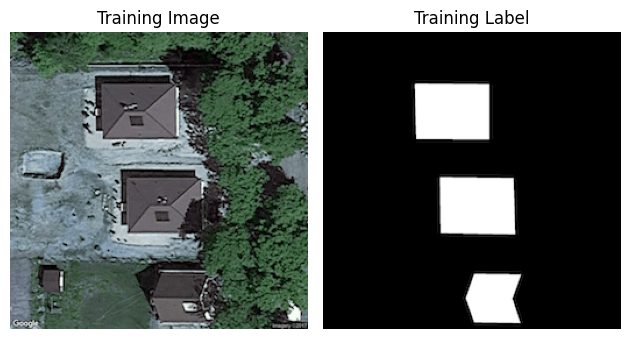

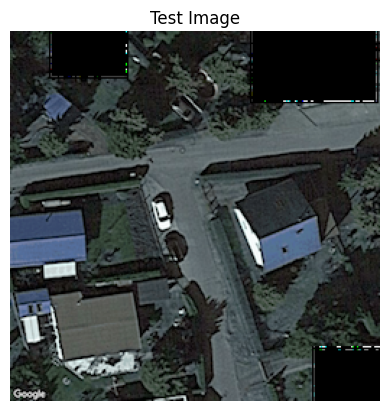

In [63]:
# Display a training image and its corresponding label
index = 0  # Adjust the index to choose a specific training sample

# Training image
plt.subplot(1, 2, 1)
plt.imshow(train_images[index])
plt.title('Training Image')
plt.axis('off')

# Training label
plt.subplot(1, 2, 2)
plt.imshow(train_labels[index], cmap='gray')
plt.title('Training Label')
plt.axis('off')

plt.tight_layout()
plt.show()

# Display a test image
test_index = 0  # Adjust the index to choose a specific test sample

plt.imshow(test_images[test_index])
plt.title('Test Image')
plt.axis('off')
plt.show()

## 1.2. Data Preprocessing

* Resize the images to a consistent resolution
* Normalize the pixel values
* Perform data augmentation techniques [This step is important since we have only 25 training samples. This will increase the training size and improve generalisation]

### 1.2.1. Resizing images to a consistent resolution

This step is not necessary. All our images are already in a (256 x 256) shape.

In [64]:
# Run this code to ensure that all images are (256x256)
'''       
for index in range(len(train_images)):

    # Get the resolution of the image
    height, width, channels = train_images[index].shape

    print(f"Image Resolution: {width}x{height}. Numer of Channels: {channels}")

for index in range(len(train_labels)):

    # Get the resolution of the image
    height, width = train_labels[index].shape

    print(f"Image Resolution: {width}x{height}.")

for index in range(len(test_images)):

    # Get the resolution of the image
    height, width, channels = test_images[index].shape

    print(f"Image Resolution: {width}x{height}. Numer of Channels: {channels}")
'''

# Otherwise, use following code to resize to (256x256)

'''
# Resize images to a consistent resolution
target_resolution = (256, 256)  # Adjust to desired resolution

def resize_image(image, resolution):
    return cv2.resize(image, resolution)

train_images = [resize_image(image, target_resolution) for image in train_images]
train_labels = [resize_image(label, target_resolution) for label in train_labels]
test_images = [resize_image(image, target_resolution) for image in test_images]
'''

'\n# Resize images to a consistent resolution\ntarget_resolution = (256, 256)  # Adjust to desired resolution\n\ndef resize_image(image, resolution):\n    return cv2.resize(image, resolution)\n\ntrain_images = [resize_image(image, target_resolution) for image in train_images]\ntrain_labels = [resize_image(label, target_resolution) for label in train_labels]\ntest_images = [resize_image(image, target_resolution) for image in test_images]\n'

### 1.2.2. Normalise Pixel values

In [65]:
# Normalize pixel values
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels) / 255.0
test_images = np.array(test_images) / 255.0

### 1.2.3. Data augmentation

This step is important since we have only 25 training samples. This will increase the training size and improve generalisation. The augmentation techniques we use here are:
* Flip horizontally with a 50% chance
* Rotate image by -20 to 20 degrees
* Scale image by 0.8 to 1.2
* Translate image by -20% to 20% on each axis
* Shear image by -20 to 20 degrees
* Zoom image by 0.8 to 1.2 on each axis


In [74]:
# Apply techniques like rotation, flipping, scaling, etc. to increase training data size
import imgaug.augmenters as iaa

augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with a 50% chance
    iaa.Affine(rotate=(-20, 20)),  # Rotate image by -20 to 20 degrees
    iaa.Affine(scale=(0.8, 1.2)),  # Scale image by 0.8 to 1.2
    iaa.Affine(translate_percent=(-0.2, 0.2)),  # Translate image by -20% to 20% on each axis
    iaa.Affine(shear=(-20, 20)),  # Shear image by -20 to 20 degrees
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),  # Zoom image by 0.8 to 1.2 on each axis
])

augmented_train_images = augmenter(images=train_images)
augmented_train_labels = augmenter(images=train_labels)
train_images = np.concatenate([train_images, augmented_train_images])
train_labels = np.concatenate([train_labels, augmented_train_labels])

How big have we made our training set? 100
Some examples:


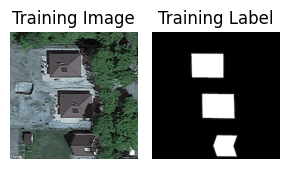

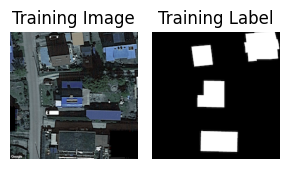

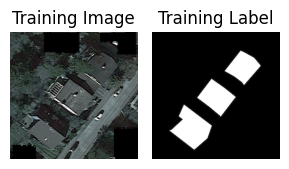

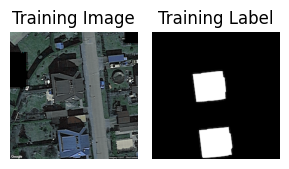

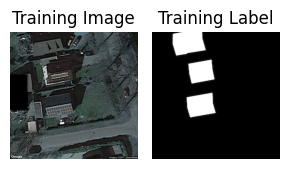

In [78]:
print(f"How big have we made our training set? {len(train_images)}")
print("Some examples:")

for index in range(len(train_images))[:5]:

    plt.figure(figsize=(3,2))
    # Training image
    plt.subplot(1, 2, 1)
    plt.imshow(train_images[index])
    plt.title('Training Image')
    plt.axis('off')

    # Training label
    plt.subplot(1, 2, 2)
    plt.imshow(train_labels[index], cmap='gray')
    plt.title('Training Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## 1.3. Train-validation split

We make a 80-20 split between our training and validation sets.

In [83]:
# Split training data into training and validation subsets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

**Save preprocessed data**

In [87]:
# Save preprocessed training images and labels
train_output_dir = '../data/preprocessed/train'
os.makedirs(train_output_dir, exist_ok=True)

for i, image in enumerate(train_images):
    image_filename = f"preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(train_output_dir, image_filename), image)

for i, label in enumerate(train_labels):
    label_filename = f"preprocessed_label_{i}.png"
    cv2.imwrite(os.path.join(train_output_dir, label_filename), label)

# Save preprocessed validation images and labels
val_output_dir = '../data/preprocessed/valid'
os.makedirs(val_output_dir, exist_ok=True)

for i, image in enumerate(val_images):
    image_filename = f"preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(val_output_dir, image_filename), image)

for i, label in enumerate(val_labels):
    label_filename = f"preprocessed_label_{i}.png"
    cv2.imwrite(os.path.join(val_output_dir, label_filename), label)

# Save preprocessed test images
test_output_dir = '../data/preprocessed/test'
os.makedirs(test_output_dir, exist_ok=True)

for i, image in enumerate(test_images):
    image_filename = f"preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(test_output_dir, image_filename), image)
